In [2]:
import deepdish
import glob
# import h5py11
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
from torchmetrics.functional import dice
from torch.utils.data import Dataset, DataLoader
import warnings
import yaml
# from pprint import pprint

warnings.filterwarnings("ignore")

In [3]:
%pwd

'/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands'

In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
data_path_mf_train = "/home/albert/ml/Contrails/data/full_dataset/train/"
data_path_mf_valid = "/home/albert/ml/Contrails/data/full_dataset/validation/"

### Create and save config

In [6]:
!mkdir "./resnest26d_ash_attention_sample_loss"

mkdir: cannot create directory ‘./resnest26d_ash_attention_sample_loss’: File exists


In [7]:
%%writefile resnest26d_ash_attention_sample_loss.yaml

output_dir: "./resnest26d_ash_attention_sample_loss"

seed: 42

train_bs: 68
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True

Overwriting resnest26d_ash_attention_sample_loss.yaml


In [8]:
with open("resnest26d_ash_attention_sample_loss.yaml", "r") as file_obj:
    resnest26d_ash_attention_sample_loss = yaml.safe_load(file_obj)

In [9]:
!mkdir "./resnest26d_ash_attention_sample_loss_diff_sched"

mkdir: cannot create directory ‘./resnest26d_ash_attention_sample_loss_diff_sched’: File exists


In [10]:
%%writefile resnest26d_ash_attention_sample_loss_diff_sched.yaml

output_dir: "./resnest26d_ash_attention_sample_loss_diff_sched"

seed: 42

train_bs: 68
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "cosine_with_hard_restarts_schedule_with_warmup"
        params:
            cosine_with_hard_restarts_schedule_with_warmup:
                num_warmup_steps: 350
                num_training_steps: 3150
                num_cycles: 1

Overwriting resnest26d_ash_attention_sample_loss_diff_sched.yaml


In [11]:
with open("resnest26d_ash_attention_sample_loss_diff_sched.yaml", "r") as file_obj:
    resnest26d_ash_attention_sample_loss_diff_sched = yaml.safe_load(file_obj)

#### 101 512

In [12]:
%%writefile resnest101e_ash_attention_sample_loss_kfold_512.yaml.yaml

output_dir: "./resnest101e_ash_attention_sample_loss_kfold_512"

folds:
    n_splits: 4
    random_state: 42
train_folds: [0, 1, 2, 3]

seed: 42

train_bs: 18
valid_bs: 18
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest101e"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True


Overwriting resnest101e_ash_attention_sample_loss_kfold_512.yaml.yaml


In [13]:
with open("resnest101e_ash_attention_sample_loss_kfold_512.yaml", "r") as file_obj:
    resnest101e_ash_attention_sample_loss_kfold_512 = yaml.safe_load(file_obj)

### Dataset for full dataset

In [14]:
class ContrailsDatasetMixed(Dataset):
    def __init__(self, split="train", mode="single", delta_t = 0):
        self.delta_t = delta_t
        self.split = split
        self.mode = mode
        self.path = (lambda x: data_path_mf_train if x == "train" else data_path_mf_valid)(self.split)
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            t_null = 4
            return false_color[..., t_null+self.delta_t]
        else:
            return false_color
    
    def __getitem__(self, index):
        path = f"{self.path}{self.examples[index]}"
        data = self.read_record(path)    
        img = self.get_false_color(data)
        if self.split == "validation":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
        if self.split == "train":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
            label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
            labelers = label_indiv[1,1,:].shape[0]
            label_union = torch.zeros([256, 256])
            for i in range(labelers):
                label_i = label_indiv[:, :,i]
                label_union[label_i[:, :] == 1] = 1   

        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)

        img = self.normalize_image(img)

        if self.split in ["train"]:
            return img.float(), [label.float(),label_union.float()]
        if self.split in ["validation"]:
            return img.float(), label.float()

        return img.float()
    
    def __len__(self):
        return len(self.examples)

### Testing new training labels

In [15]:
# dataset_train = ContrailsDatasetMixed()
# img, _ = dataset_train.__getitem__(5886)
# img.shape

In [16]:
# path = "/home/albert/ml/Contrails/data/full_dataset/train/8048905517782272978"
# label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
# label_indiv.shape

# import matplotlib.pyplot as plt
# import numpy as np
# fig, axs = plt.subplots(1, 8, figsize=(20, 4))
# for i in range(7):
#     axs[i].imshow(label_indiv[:,:,i], cmap='gray') 
# # axs[i].axis('off')

# img, _ = dataset_train.__getitem__(5886)
# axs[7].imshow(img.permute(1,2,0)) 
# plt.show()



### Lightning Module

#### Tversky loss

In [17]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

class LightningModuleTrLoss(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # print(config["aux_params"])
        self.model = model = smp.Unet(
            encoder_name=config["encoder_name"],
            encoder_depth=config["encoder_depth"],
            decoder_channels = (256, 128, 64, 32,16)[:config["encoder_depth"]],
            # aux_params = config["aux_params"],
            decoder_attention_type =config["decoder_attention_type"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.alpha = config["alpha"]
        self.beta = config["beta"]
        self.alpha_union = config["alpha_union"]
        self.beta_union = config["beta_union"]

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}


    def training_step(self, batch, batch_idx):
        imgs, [label_gt,label_union] = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss_ground_truth = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha, beta=self.beta, gamma=1.0)(preds, label_gt)
        loss_union = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha_union, beta=self.beta_union, gamma=1.0)(preds, label_union)
        loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"])+torch.mul(loss_union, self.config["weight_union"])
        self.log('loss_union', float(loss_union) , on_step=False, on_epoch=True, prog_bar=True) #, batch_size=16
        self.log('loss_ground_truth', float(loss_ground_truth) , on_step=False, on_epoch=True, prog_bar=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

In [18]:
class LightningModuleTrLoss512(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # print(config["aux_params"])
        self.model = model = smp.Unet(
            encoder_name=config["encoder_name"],
            encoder_depth=config["encoder_depth"],
            decoder_channels = (256, 128, 64, 32,16)[:config["encoder_depth"]],
            # aux_params = config["aux_params"],
            decoder_attention_type =config["decoder_attention_type"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.alpha = config["alpha"]
        self.beta = config["beta"]
        self.alpha_union = config["alpha_union"]
        self.beta_union = config["beta_union"]

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, [label_gt,label_union] = batch
        imgs = torch.nn.functional.interpolate(imgs, size=512, mode='bilinear')
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss_ground_truth = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha, beta=self.beta, gamma=1.0)(preds, label_gt)
        loss_union = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha_union, beta=self.beta_union, gamma=1.0)(preds, label_union)
        loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"])+torch.mul(loss_union, self.config["weight_union"])
        self.log('loss_union', float(loss_union) , on_step=False, on_epoch=True, prog_bar=True) #, batch_size=16
        self.log('loss_ground_truth', float(loss_ground_truth) , on_step=False, on_epoch=True, prog_bar=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs = torch.nn.functional.interpolate(imgs, size=512, mode='bilinear')
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

### Training functions

In [19]:
def sample_union_loss(delta, cfg, module,alpha, alpha_union, weight_ground_truth):
    cfg['model']["alpha"] = alpha
    cfg['model']["beta"] = 1-alpha
    cfg['model']["alpha_union"] = alpha_union
    cfg['model']["beta_union"] = 1-alpha_union
    cfg['model']["weight_ground_truth"] = weight_ground_truth
    cfg['model']["weight_union"] = 1-weight_ground_truth
    identifier = "resnest101e_alpha="+str(alpha)+"_alpha_union="+str(alpha_union)+"_weight_ground_truth="+str(weight_ground_truth)
    dataset_train = ContrailsDatasetMixed("train", "single",delta)
    dataset_validation = ContrailsDatasetMixed("validation","single", delta)
    
    data_loader_train = DataLoader(
    dataset_train,
    batch_size=cfg["train_bs"],
    shuffle=True,
    num_workers=cfg["workers"],
    )
    
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=cfg["valid_bs"],
        shuffle=False,
        num_workers=cfg["workers"],
    )
    
    checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=cfg["output_dir"],
    mode="max",
    filename= identifier,
    save_top_k=1,
    verbose=1,
    )
    progress_bar_callback = TQDMProgressBar(
    refresh_rate=cfg["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**cfg["early_stop"])
    csv_logger = CSVLogger(cfg["output_dir"], name=identifier)
    trainer = L.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger = csv_logger,
        **cfg["trainer"],
    )
    
    # cfg["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/cfg["trainer"]["devices"]
    model = module(cfg["model"])
    
    trainer.fit(model, data_loader_train, data_loader_validation)
    
    

### Training the timesteps

In [ ]:
for weight_ground_truth in [0.6,0.7,0.8]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            # sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 25.3 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
25.3 M    Trainable params
0         Non-trainable params
25.3 M    Total params
101.314   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.507
Epoch 0, global step 302: 'val_dice' reached 0.51750 (best 0.51750), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.35_alpha_union=0.4_weight_ground_truth=0.6.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.448
Epoch 1, global step 604: 'val_dice' reached 0.57224 (best 0.57224), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.35_alpha_union=0.4_weight_ground_truth=0.6.ckpt' as top 1


### Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,20))
for weight_ground_truth in [0.6]:
    print("")
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            print(label + " max: {:.3f}".format(maximum))
plt.legend()
plt.show()


alpha=0.35_alpha_union=0.4_weight_ground_truth=0.7 max: 0.612
alpha=0.35_alpha_union=0.6_weight_ground_truth=0.7 max: 0.613
alpha=0.35_alpha_union=0.8_weight_ground_truth=0.7 max: 0.613


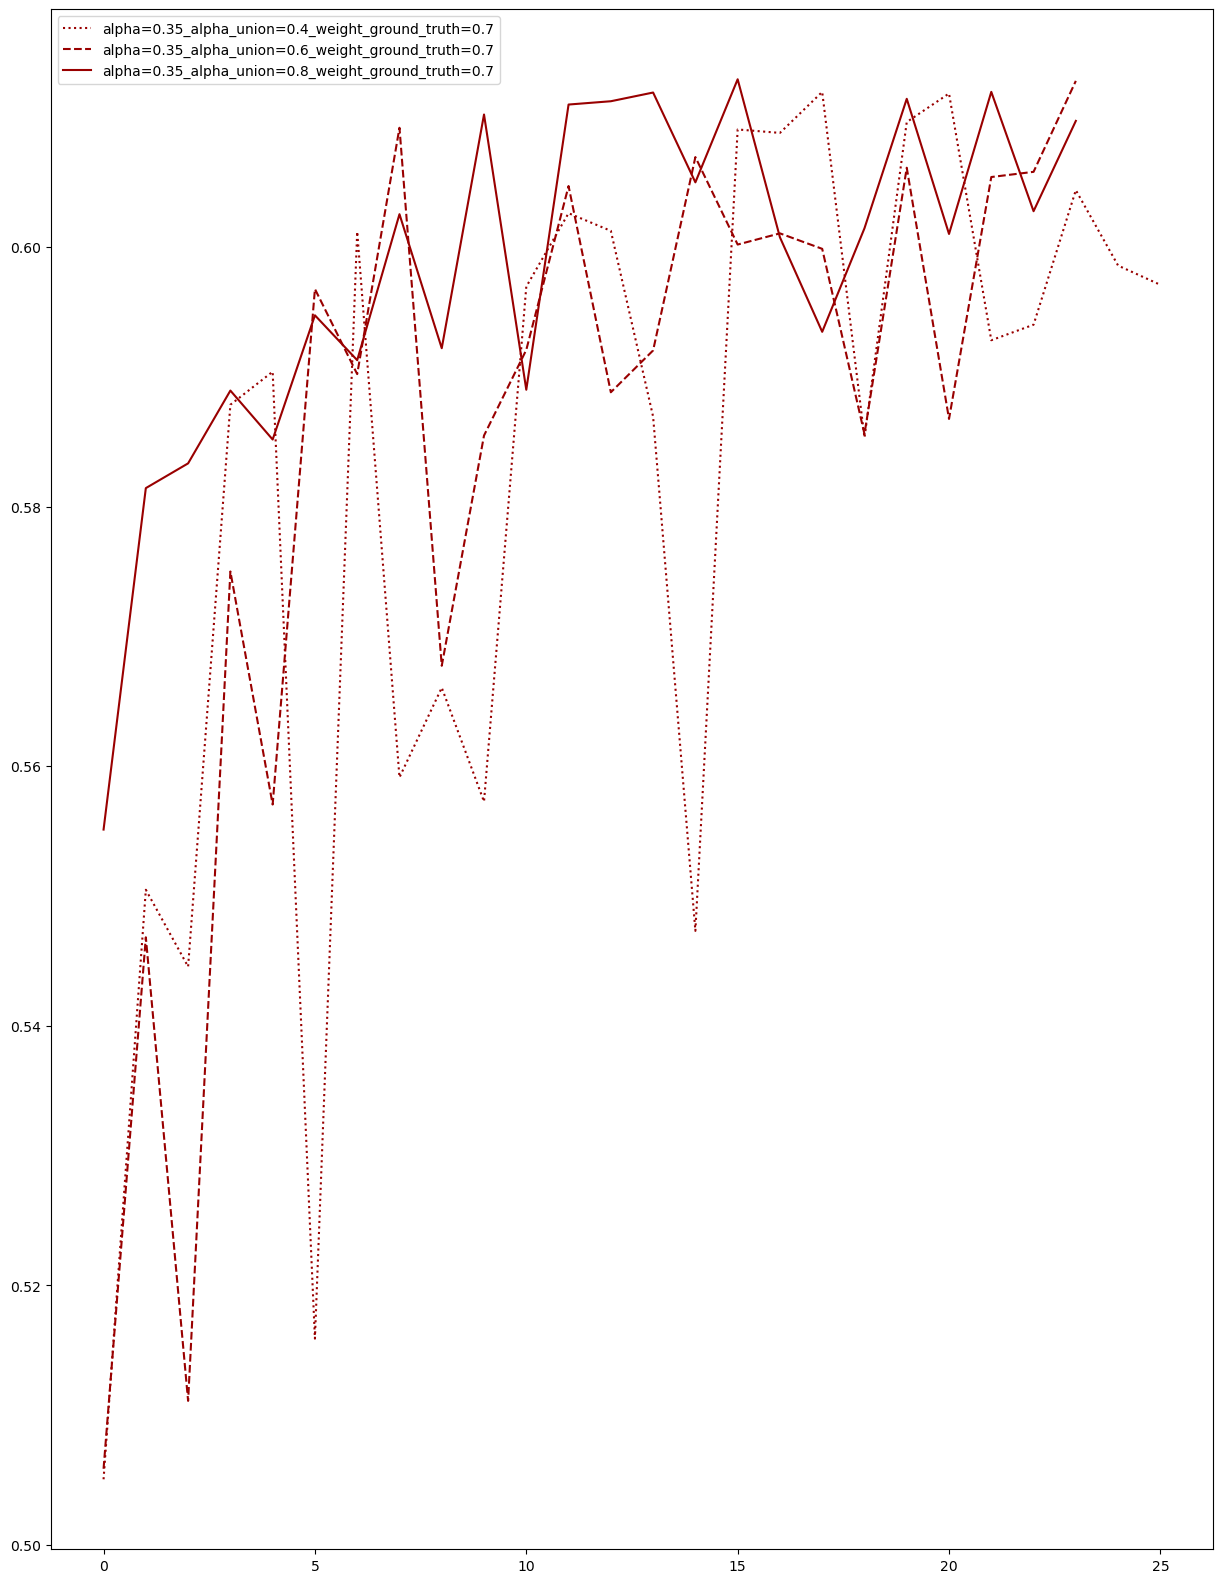

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,20))
for weight_ground_truth in [0.7]:
    print("")
    for alpha in [0.35]: #[0.35,0.5,0.65]
        for alpha_union in [0.4,0.6,0.8]:
            path = f"/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            print(label + " max: {:.3f}".format(maximum))
plt.legend()
plt.show()

In [ ]:
Continue to train alpha 0.5 alpha union 0.6 model -> seems to continue to improve

 max: 0.612 alpha=0.35_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.613 alpha=0.35_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.613 alpha=0.35_alpha_union=0.8_weight_ground_truth=0.7
 max: 0.615 alpha=0.5_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.619 alpha=0.5_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.616 alpha=0.5_alpha_union=0.8_weight_ground_truth=0.7
 max: 0.610 alpha=0.65_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.619 alpha=0.65_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.615 alpha=0.65_alpha_union=0.8_weight_ground_truth=0.7


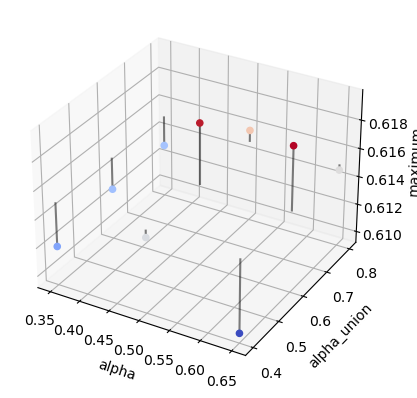

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

data = []
dice_list = []
for weight_ground_truth in [0.7]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            data.append([alpha, alpha_union, maximum])
            dice_list.append(f" max: {maximum:.3f} "+label)

dice_list.sort
for element in dice_list: print(element)

import matplotlib.pyplot as plt

x = [i[0] for i in data]
y = [i[1] for i in data]
z = [i[2] for i in data]

# plt.figure(figsize=(15,15))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid
X,Y = np.meshgrid(x,y)

# Interpolate the data
from scipy.interpolate import griddata
Z = griddata((x,y), z, (X,Y), method='cubic')

# Plot the points with a color gradient
ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)

# Add a color bar which maps values to colors
# fig.colorbar(surf)

# Plot lines from points to surface
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [0.615, z[i]], color='black', alpha=0.5)

# Plot the surface
ax.set_xlabel('alpha')
ax.set_ylabel('alpha_union')
ax.set_zlabel('maximum')

plt.show()

 max: 0.607 alpha=0.35_alpha_union=0.4_weight_ground_truth=0.6
 max: 0.612 alpha=0.35_alpha_union=0.6_weight_ground_truth=0.6
 max: 0.614 alpha=0.35_alpha_union=0.8_weight_ground_truth=0.6
 max: 0.616 alpha=0.5_alpha_union=0.4_weight_ground_truth=0.6
 max: 0.623 alpha=0.5_alpha_union=0.6_weight_ground_truth=0.6
 max: 0.625 alpha=0.5_alpha_union=0.8_weight_ground_truth=0.6
 max: 0.615 alpha=0.65_alpha_union=0.4_weight_ground_truth=0.6
 max: 0.619 alpha=0.65_alpha_union=0.6_weight_ground_truth=0.6
 max: 0.616 alpha=0.65_alpha_union=0.8_weight_ground_truth=0.6


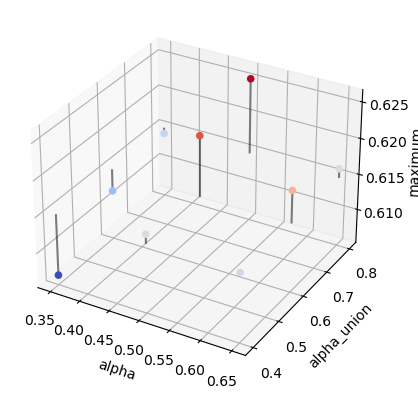

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

data = []
dice_list = []

for weight_ground_truth in [0.6]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            data.append([alpha, alpha_union, maximum])
            dice_list.append(f" max: {maximum:.3f} "+label)

dice_list.sort
for element in dice_list: print(element)



import matplotlib.pyplot as plt

x = [i[0] for i in data]
y = [i[1] for i in data]
z = [i[2] for i in data]

# plt.figure(figsize=(15,15))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid
X,Y = np.meshgrid(x,y)

# Interpolate the data
from scipy.interpolate import griddata
Z = griddata((x,y), z, (X,Y), method='cubic')

# Plot the points with a color gradient
ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)

# Add a color bar which maps values to colors
# fig.colorbar(surf)

# Plot lines from points to surface
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [0.615, z[i]], color='black', alpha=0.5)

# Plot the surface
ax.set_xlabel('alpha')
ax.set_ylabel('alpha_union')
ax.set_zlabel('maximum')

plt.show()

## Iterate and explore further

In [ ]:
for weight_ground_truth in [0.55,0.45]:
    for alpha in [0.45,0.5]:
        for alpha_union in [0.75,0.85]:
            sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 25.3 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
25.3 M    Trainable params
0         Non-trainable params
25.3 M    Total params
101.314   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.450
Epoch 0, global step 302: 'val_dice' reached 0.56546 (best 0.56546), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.45_alpha_union=0.75_weight_ground_truth=0.55.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Epoch 1, global step 604: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.429
Epoch 2, global step 906: 'val_dice' reached 0.57816 (best 0.57816), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.45_alpha_union=0.75_weight_ground_truth=0.55.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.424
Epoch 3, global step 1208: 'val_dice' reached 0.58336 (best 0.58336), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.45_alpha_union=0.75_weight_ground_truth=0.55.ckpt' as top 1


In [17]:
alpha = 0.5
alpha_union = 0.90
weight_ground_truth = 0.45
sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 25.3 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
25.3 M    Trainable params
0         Non-trainable params
25.3 M    Total params
101.314   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.476
Epoch 0, global step 302: 'val_dice' reached 0.53847 (best 0.53847), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.444
Epoch 1, global step 604: 'val_dice' reached 0.56334 (best 0.56334), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Epoch 2, global step 906: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.415
Epoch 3, global step 1208: 'val_dice' reached 0.59199 (best 0.59199), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Epoch 4, global step 1510: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.413
Epoch 5, global step 1812: 'val_dice' reached 0.59552 (best 0.59552), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.400
Epoch 6, global step 2114: 'val_dice' reached 0.60671 (best 0.60671), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Epoch 7, global step 2416: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Epoch 8, global step 2718: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.399
Epoch 9, global step 3020: 'val_dice' reached 0.60743 (best 0.60743), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.394
Epoch 10, global step 3322: 'val_dice' reached 0.61212 (best 0.61212), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Epoch 11, global step 3624: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 3926: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 13


Epoch 13, global step 4228: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 14


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.392
Epoch 14, global step 4530: 'val_dice' reached 0.61270 (best 0.61270), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 15


Epoch 15, global step 4832: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 16


Epoch 16, global step 5134: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 17


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.389
Epoch 17, global step 5436: 'val_dice' reached 0.61668 (best 0.61668), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 18


Epoch 18, global step 5738: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 19


Epoch 19, global step 6040: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 20


Epoch 20, global step 6342: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 21


Epoch 21, global step 6644: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 22


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.385
Epoch 22, global step 6946: 'val_dice' reached 0.62001 (best 0.62001), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.9_weight_ground_truth=0.45.ckpt' as top 1


In [29]:
alpha = 0.5
alpha_union = 0.85
weight_ground_truth = 0.45
sample_union_loss(0, resnest26d_ash_attention_sample_loss_diff_sched, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 25.3 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
25.3 M    Trainable params
0         Non-trainable params
25.3 M    Total params
101.314   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.512
Epoch 0, global step 302: 'val_dice' reached 0.52243 (best 0.52243), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.468
Epoch 1, global step 604: 'val_dice' reached 0.54213 (best 0.54213), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.425
Epoch 2, global step 906: 'val_dice' reached 0.58344 (best 0.58344), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.418
Epoch 3, global step 1208: 'val_dice' reached 0.58935 (best 0.58935), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Epoch 4, global step 1510: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.395
Epoch 5, global step 1812: 'val_dice' reached 0.61148 (best 0.61148), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.390
Epoch 6, global step 2114: 'val_dice' reached 0.61738 (best 0.61738), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Epoch 7, global step 2416: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.387
Epoch 8, global step 2718: 'val_dice' reached 0.61922 (best 0.61922), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Epoch 9, global step 3020: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.386
Epoch 10, global step 3322: 'val_dice' reached 0.62033 (best 0.62033), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss_diff_sched/resnest101e_alpha=0.5_alpha_union=0.85_weight_ground_truth=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Epoch 11, global step 3624: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 3926: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 13


Epoch 13, global step 4228: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 14


Epoch 14, global step 4530: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 15


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.386. Signaling Trainer to stop.
Epoch 15, global step 4832: 'val_dice' was not in top 1
Trainer was signaled to stop but the required `min_epochs=24` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]


Epoch: 16


Monitored metric val_loss did not improve in the last 6 records. Best score: 0.386. Signaling Trainer to stop.
Epoch 16, global step 5134: 'val_dice' was not in top 1
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


In [ ]:
alpha = 0.5
alpha_union = 0.85
weight_ground_truth = 1
sample_union_loss(0, resnest26d_ash_attention_sample_loss_diff_sched, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

Decoder_Attention max: 0.625
Decoder_Attention_Tversky_a6b4 max: 0.628
Decoder_Attention_Tversky_a4b6 max: 0.621
Decoder_Attention_512 max: 0.628


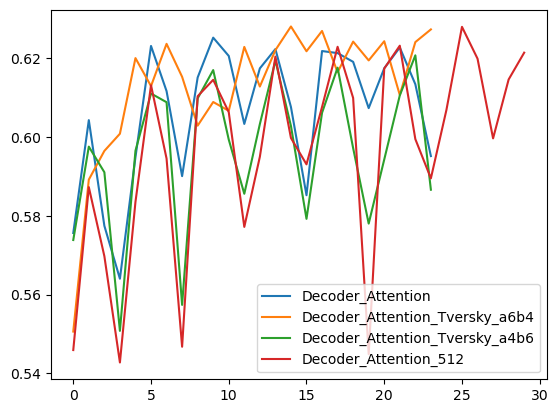

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

def plotDice(metrics_per_model):
    for model_label in metrics_per_model.keys():
        metrics = pd.read_csv(metrics_per_model[model_label])
        metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
        plt.plot(metrics['val_dice'], label=model_label)

        maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
        print(model_label + " max: {:.3f}".format(maximum))

    plt.legend()
    plt.show()
plotDice(metrics_per_model)

## Trying 512+long training on best model


In [20]:
sample_union_loss(0, resnest101e_ash_attention_sample_loss_kfold_512, LightningModuleTrLoss512, alpha = 0.5,alpha_union = 0.81, weight_ground_truth = 0.5)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 56.6 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.221   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.448
Epoch 0, global step 1027: 'val_dice' reached 0.57075 (best 0.57075), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.431
Epoch 1, global step 2054: 'val_dice' reached 0.57997 (best 0.57997), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.430
Epoch 2, global step 3081: 'val_dice' reached 0.58243 (best 0.58243), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.404
Epoch 3, global step 4108: 'val_dice' reached 0.60587 (best 0.60587), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Epoch 4, global step 5135: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Epoch 5, global step 6162: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.400
Epoch 6, global step 7189: 'val_dice' reached 0.60955 (best 0.60955), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Epoch 7, global step 8216: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Epoch 8, global step 9243: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.387
Epoch 9, global step 10270: 'val_dice' reached 0.61897 (best 0.61897), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.378
Epoch 10, global step 11297: 'val_dice' reached 0.62831 (best 0.62831), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Epoch 11, global step 12324: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 13351: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 13


Epoch 13, global step 14378: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 14


Epoch 14, global step 15405: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 15


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.378. Signaling Trainer to stop.
Epoch 15, global step 16432: 'val_dice' was not in top 1
Trainer was signaled to stop but the required `min_epochs=24` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]


Epoch: 16


Monitored metric val_loss did not improve in the last 6 records. Best score: 0.378. Signaling Trainer to stop.
Epoch 16, global step 17459: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 17


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.374
Epoch 17, global step 18486: 'val_dice' reached 0.63226 (best 0.63226), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.81_weight_ground_truth=0.5-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 18


Epoch 18, global step 19513: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 19


Epoch 19, global step 20540: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 20


Epoch 20, global step 21567: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 21


Epoch 21, global step 22594: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 22


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.374
Epoch 22, global step 23621: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 23


Epoch 23, global step 24648: 'val_dice' was not in top 1


## Baseline

In [135]:
sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = 0.5,alpha_union = 0.5, weight_ground_truth = 1)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 25.3 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
25.3 M    Trainable params
0         Non-trainable params
25.3 M    Total params
101.314   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.498
Epoch 0, global step 302: 'val_dice' reached 0.52061 (best 0.52061), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.457
Epoch 1, global step 604: 'val_dice' reached 0.55547 (best 0.55547), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.455
Epoch 2, global step 906: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.426
Epoch 3, global step 1208: 'val_dice' reached 0.58091 (best 0.58091), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Epoch 4, global step 1510: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.411
Epoch 5, global step 1812: 'val_dice' reached 0.59485 (best 0.59485), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Epoch 6, global step 2114: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.406
Epoch 7, global step 2416: 'val_dice' reached 0.60106 (best 0.60106), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Epoch 8, global step 2718: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Epoch 9, global step 3020: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.404
Epoch 10, global step 3322: 'val_dice' reached 0.60125 (best 0.60125), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.394
Epoch 11, global step 3624: 'val_dice' reached 0.61328 (best 0.61328), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest26d_ash_attention_sample_loss/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 3926: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 13


Epoch 13, global step 4228: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 14


Epoch 14, global step 4530: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 15


Epoch 15, global step 4832: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 16


Monitored metric val_loss did not improve in the last 5 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 16, global step 5134: 'val_dice' was not in top 1
Trainer was signaled to stop but the required `min_epochs=24` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]


Epoch: 17


Monitored metric val_loss did not improve in the last 6 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 17, global step 5436: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 18


Monitored metric val_loss did not improve in the last 7 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 18, global step 5738: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 19


Monitored metric val_loss did not improve in the last 8 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 19, global step 6040: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 20


Monitored metric val_loss did not improve in the last 9 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 20, global step 6342: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 21


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 21, global step 6644: 'val_dice' was not in top 1


In [ ]:
sample_union_loss(0, resnest101e_ash_attention_sample_loss_kfold_512, LightningModuleTrLoss512, alpha = 0.5,alpha_union = 0.5, weight_ground_truth = 1)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Unet     | 56.6 M
1 | loss_module | DiceLoss | 0     
-----------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.221   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Metric val_loss improved. New best score: 0.455
Epoch 0, global step 1027: 'val_dice' reached 0.56197 (best 0.56197), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 1


Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.428
Epoch 1, global step 2054: 'val_dice' reached 0.58437 (best 0.58437), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Epoch 2, global step 3081: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 3


Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.411
Epoch 3, global step 4108: 'val_dice' reached 0.59703 (best 0.59703), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 4


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.393
Epoch 4, global step 5135: 'val_dice' reached 0.61635 (best 0.61635), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 5


Epoch 5, global step 6162: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 6


Epoch 6, global step 7189: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 7


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.392
Epoch 7, global step 8216: 'val_dice' reached 0.61875 (best 0.61875), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 8


Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.384
Epoch 8, global step 9243: 'val_dice' reached 0.62507 (best 0.62507), saving model to '/home/albert/ml/Contrails/notebooks/full_dataset/test_use_all_bands/resnest101e_ash_attention_sample_loss_kfold_512/resnest101e_alpha=0.5_alpha_union=0.5_weight_ground_truth=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]


Epoch: 9


Epoch 9, global step 10270: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 10


Epoch 10, global step 11297: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 11


Epoch 11, global step 12324: 'val_dice' was not in top 1


Validation: 0it [00:00, ?it/s]


Epoch: 12


Epoch 12, global step 13351: 'val_dice' was not in top 1


1. Bei nicht benutzung von k folds und den unterschiedlichen verteilungen der klassen in val/train ist tversky_loss mit a>b marginal besser als dice loss in val_dice
2. Image size größer scheint val_dice zu verbessern bei verlängerter lr
